<a href="https://colab.research.google.com/github/nrimsky/mlexperiments/blob/main/modular_addition/modular_addition_network_dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install einops

In [2]:
import torch as t
import einops
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from torch.autograd import grad

# Constants

In [3]:
P = 53
TRAIN_FRAC = 0.7
HIDDEN_SIZE = 64
LR = 0.01
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
BATCH_SIZE = 256
EMBED_DIM = 6

# Model architecture

In [4]:
class MLP(t.nn.Module):
    def __init__(self, embed_dim, vocab_size, hidden_dim, tie_unembed=False):
        super().__init__()
        self.embedding = t.nn.Embedding(vocab_size, embed_dim)
        self.linear1 = t.nn.Linear(embed_dim, hidden_dim, bias=True)
        self.tie_unembed = tie_unembed
        if tie_unembed:
          self.linear2 = t.nn.Linear(hidden_dim, embed_dim, bias=True)
        else:
          self.linear2 = t.nn.Linear(hidden_dim, vocab_size, bias=True)
        self.gelu = t.nn.GELU()
        self.vocab_size = vocab_size

    def forward(self, x1, x2):
        x1 = self.embedding(x1)
        x2 = self.embedding(x2)
        x1 = self.linear1(x1)
        x2 = self.linear1(x2)
        x = x1 + x2
        x = self.gelu(x)
        x = self.linear2(x)
        if self.tie_unembed:
          x = x @ self.embedding.weight.T
        return x

# Make dataset

In [5]:
def get_all_pairs(p):
  pairs = []
  for i in range(p):
    for j in range(p):
      pairs.append((i,j))
  return set(pairs)

In [6]:
def make_dataset(p):
  data = []
  pairs = get_all_pairs(p)
  for a, b in pairs:
    data.append(((t.tensor(a), t.tensor(b)), t.tensor((a + b) % p)))
  return data


In [7]:
make_dataset(3)

[((tensor(0), tensor(1)), tensor(1)),
 ((tensor(1), tensor(2)), tensor(0)),
 ((tensor(2), tensor(1)), tensor(0)),
 ((tensor(0), tensor(0)), tensor(0)),
 ((tensor(1), tensor(1)), tensor(2)),
 ((tensor(2), tensor(0)), tensor(2)),
 ((tensor(0), tensor(2)), tensor(2)),
 ((tensor(2), tensor(2)), tensor(1)),
 ((tensor(1), tensor(0)), tensor(1))]

In [8]:
def train_test_split(dataset, train_split_proportion):
  l = len(dataset)
  train_len = int(train_split_proportion * l)
  idx = list(range(l))
  random.shuffle(idx)
  train_idx = idx[:train_len]
  test_idx = idx[train_len:]
  return [dataset[i] for i in train_idx], [dataset[i] for i in test_idx]

In [9]:
dataset = make_dataset(P)

In [10]:
train_data, test_data = train_test_split(dataset, TRAIN_FRAC)

In [11]:
len(train_data), len(test_data)

(1966, 843)

# Training

In [12]:
def test(model, dataset, device):
  n_correct = 0
  model.eval()
  with t.no_grad():
    for (x1, x2), y in dataset:
      out = model(x1.to(device), x2.to(device)).cpu()
      pred = t.argmax(out)
      if pred == y:
        n_correct += 1
  return n_correct / len(dataset)

In [13]:
def train(model, train_dataset, test_dataset, batch_size, lr, n_batches, device):
  model = model.to(device)
  optimizer = t.optim.Adam(model.parameters(), weight_decay=0.0002, lr=lr)
  loss_fn = t.nn.CrossEntropyLoss()
  idx = list(range(len(train_dataset)))
  avg_loss = 0
  print_every = n_batches // 20
  for i in tqdm(range(n_batches)):
    model.train()
    # Sample random batch of data
    batch_idx = random.sample(idx, batch_size)
    X_1 = t.stack([train_dataset[b][0][0] for b in batch_idx]).to(device)
    X_2 = t.stack([train_dataset[b][0][1] for b in batch_idx]).to(device)
    Y = t.stack([train_dataset[b][1] for b in batch_idx]).to(device)
    # Gradient update
    optimizer.zero_grad()
    out = model(X_1, X_2)
    loss = loss_fn(out, Y)
    avg_loss += loss.item()
    loss.backward()
    optimizer.step()
    if i % print_every == 0:
      val_acc = test(model, test_dataset, device)
      avg_loss /= print_every
      print(f"Batch: {i} | Loss: {avg_loss} | Val Acc: {val_acc}")
      avg_loss = 0
  val_acc = test(model, test_dataset, device)
  print(f"Final Val Acc: {val_acc}")
  return model

In [14]:
model = MLP(embed_dim=EMBED_DIM, vocab_size=P, hidden_dim=HIDDEN_SIZE)
model = train(
    model=model,
    train_dataset=train_data,
    test_dataset=test_data,
    batch_size=BATCH_SIZE,
    lr=LR,
    n_batches = 10000,
    device = device
  )

  0%|          | 38/10000 [00:00<03:06, 53.33it/s] 

Batch: 0 | Loss: 0.008057975769042968 | Val Acc: 0.017793594306049824


  6%|▌         | 571/10000 [00:02<00:41, 227.86it/s]

Batch: 500 | Loss: 2.1875274197459222 | Val Acc: 0.8090154211150652


 10%|█         | 1034/10000 [00:04<00:40, 221.73it/s]

Batch: 1000 | Loss: 0.10083923283219337 | Val Acc: 0.9418742586002372


 15%|█▌        | 1529/10000 [00:07<01:57, 71.88it/s]

Batch: 1500 | Loss: 0.040052698276937006 | Val Acc: 0.9395017793594306


 20%|██        | 2021/10000 [00:10<01:26, 91.76it/s] 

Batch: 2000 | Loss: 0.03364085824787617 | Val Acc: 0.9454329774614472


 25%|██▌       | 2545/10000 [00:13<00:57, 128.96it/s]

Batch: 2500 | Loss: 0.03207541898265481 | Val Acc: 0.9478054567022538


 30%|███       | 3039/10000 [00:16<01:01, 113.03it/s]

Batch: 3000 | Loss: 0.03184916628524661 | Val Acc: 0.9537366548042705


 35%|███▌      | 3549/10000 [00:20<00:32, 196.01it/s]

Batch: 3500 | Loss: 0.030528388373553754 | Val Acc: 0.963226571767497


 40%|████      | 4043/10000 [00:22<00:21, 273.19it/s]

Batch: 4000 | Loss: 0.03106418479979038 | Val Acc: 0.9620403321470937


 46%|████▌     | 4550/10000 [00:23<00:20, 271.26it/s]

Batch: 4500 | Loss: 0.028609133053570986 | Val Acc: 0.9644128113879004


 50%|█████     | 5041/10000 [00:25<00:18, 263.11it/s]

Batch: 5000 | Loss: 0.03054353239759803 | Val Acc: 0.9620403321470937


 55%|█████▌    | 5546/10000 [00:26<00:16, 267.15it/s]

Batch: 5500 | Loss: 0.027824257273226977 | Val Acc: 0.9620403321470937


 60%|██████    | 6050/10000 [00:28<00:14, 273.17it/s]

Batch: 6000 | Loss: 0.02829008252173662 | Val Acc: 0.966785290628707


 66%|██████▌   | 6550/10000 [00:29<00:12, 265.98it/s]

Batch: 6500 | Loss: 0.028748553182929754 | Val Acc: 0.9715302491103203


 70%|███████   | 7030/10000 [00:31<00:18, 164.81it/s]

Batch: 7000 | Loss: 0.02786015072464943 | Val Acc: 0.9644128113879004


 76%|███████▌  | 7555/10000 [00:33<00:08, 275.72it/s]

Batch: 7500 | Loss: 0.027182972475886344 | Val Acc: 0.9727164887307236


 81%|████████  | 8055/10000 [00:34<00:07, 270.18it/s]

Batch: 8000 | Loss: 0.027601517632603646 | Val Acc: 0.9644128113879004


 86%|████████▌ | 8555/10000 [00:36<00:05, 273.12it/s]

Batch: 8500 | Loss: 0.027449866395443678 | Val Acc: 0.9679715302491103


 90%|█████████ | 9038/10000 [00:37<00:04, 217.06it/s]

Batch: 9000 | Loss: 0.027738112572580575 | Val Acc: 0.966785290628707


 96%|█████████▌| 9555/10000 [00:39<00:01, 270.76it/s]

Batch: 9500 | Loss: 0.02684813718497753 | Val Acc: 0.9679715302491103


100%|██████████| 10000/10000 [00:40<00:00, 247.27it/s]


Final Val Acc: 0.9679715302491103


# Fourier transform

In [19]:
cos = t.zeros((P, P))
sin = t.zeros((P, P))
for i in range(P):
  for j in range(P):
    theta = t.tensor(2 * t.pi * i * j / P)
    cos[i, j] = t.cos(theta)
    sin[i, j] = t.sin(theta)


def get_weights_modes(weights):
  c1 = cos @ (weights @ weights.T)
  s1 = sin @ (weights @ weights.T)
  return c1, s1


def ablate_other_modes(weights, modes):
    c1 = cos @ weights
    s1 = sin @ weights
    mask = t.zeros_like(c1)
    mask[modes] = 1
    mask[-1 * t.tensor(modes) + (P-1)] = 1
    c1 *= mask
    s1 *= mask
    c1 = cos @ c1 / P
    s1 = sin @ s1 / P
    return c1 + s1


In [20]:
def show_weights_modes(weights, title="Modes"):
  c1, s1 = get_weights_modes(weights)
  n_plots = (P // 2) + 1
  num_cols = int(math.ceil(math.sqrt(n_plots)))
  num_rows = int(math.ceil(n_plots / num_cols))
  colormap = plt.cm.rainbow
  plt.figure(figsize=(num_cols * 2, num_rows * 2))
  colors = [colormap(i) for i in np.linspace(0, 1, P)]
  norms = []
  for mode in range(n_plots):
    cos = c1[mode]
    sin = s1[mode]
    plt.subplot(num_rows, num_cols, mode + 1)
    color_idx = [(i * mode) % P for i in range(P)]
    color_for_mode = [colors[idx] for idx in color_idx]
    avg_norm = sum([np.sqrt(cos[i]**2 + sin[i]**2) for i in range(len(cos))])
    norms.append(avg_norm)
    plt.scatter(cos.numpy(), sin.numpy(), c=color_for_mode)
    plt.title(f"Mode {mode} {avg_norm:.4f}", fontsize=8)
  plt.suptitle(title)
  norm = Normalize(vmin=0, vmax=P)
  sm = ScalarMappable(cmap=colormap, norm=norm)
  cbar_ax = plt.gcf().add_axes([0.92, 0.15, 0.01, 0.7])
  plt.colorbar(sm, cax=cbar_ax)
  plt.tight_layout(rect=[0, 0, 0.9, 1])
  plt.show()

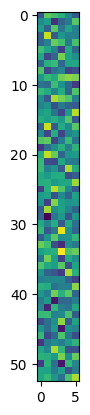

In [21]:
plt.imshow(model.embedding.weight.detach().cpu())

<ipython-input-20-1826daf31b27>:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


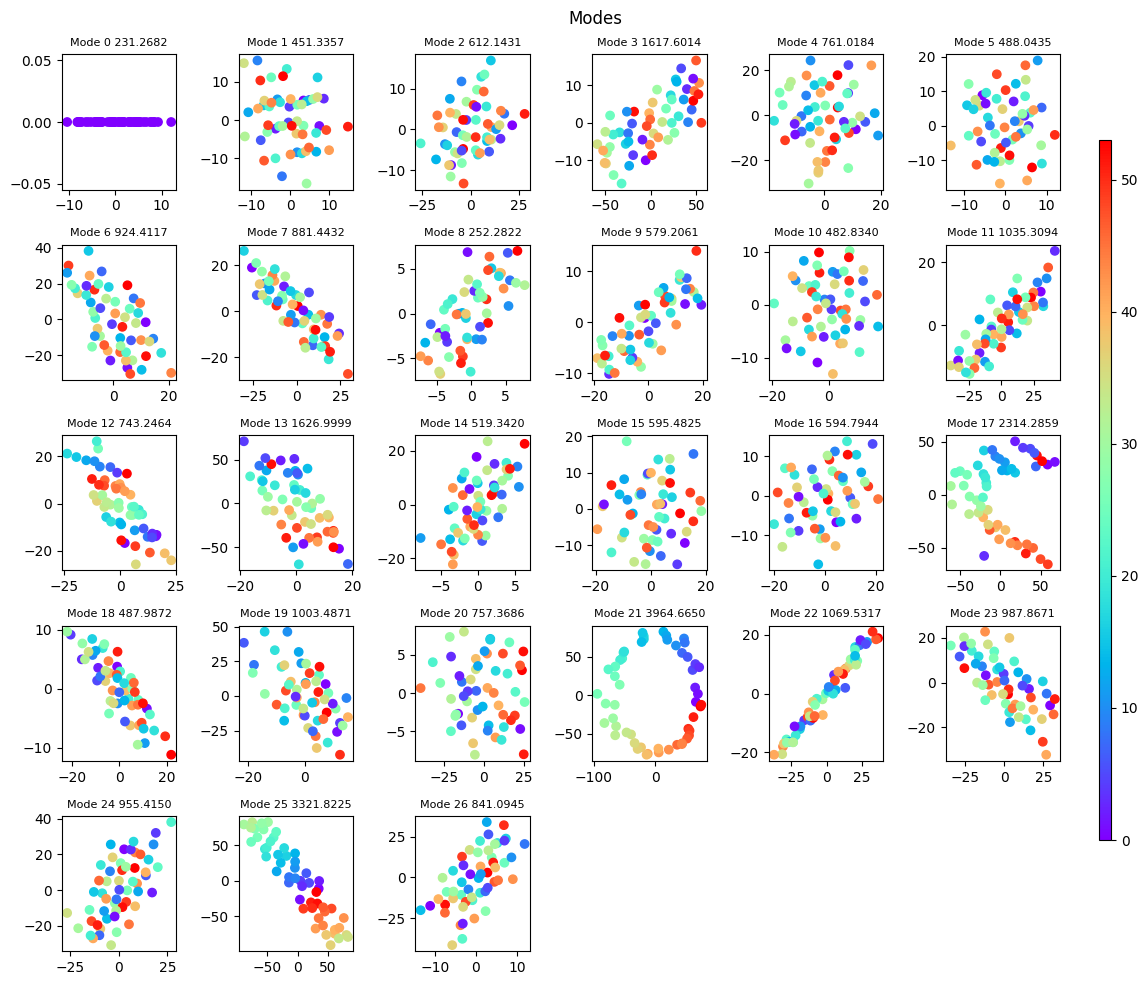

In [22]:
show_weights_modes(model.embedding.weight.detach().cpu())

In [23]:
c, s = get_weights_modes(model.embedding.weight.detach().cpu())

In [24]:
mags = (c**2 + s**2).mean(dim=-1)

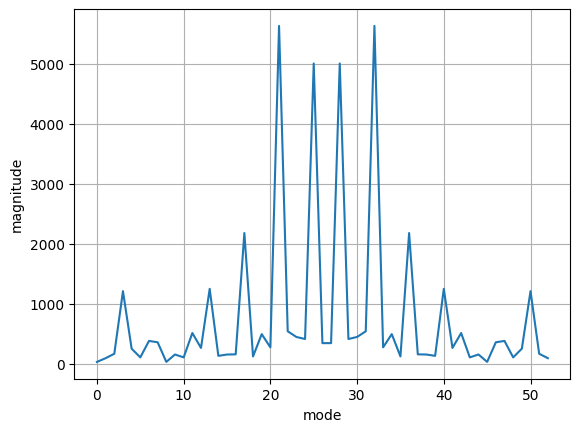

In [25]:
plt.plot(mags)
plt.xlabel("mode")
plt.ylabel("magnitude")
plt.grid()
plt.show()

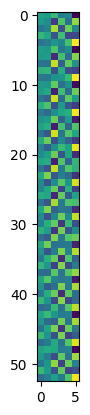

In [28]:
plt.imshow(ablate_other_modes(model.embedding.weight.detach().cpu(), [21]))

<ipython-input-20-1826daf31b27>:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


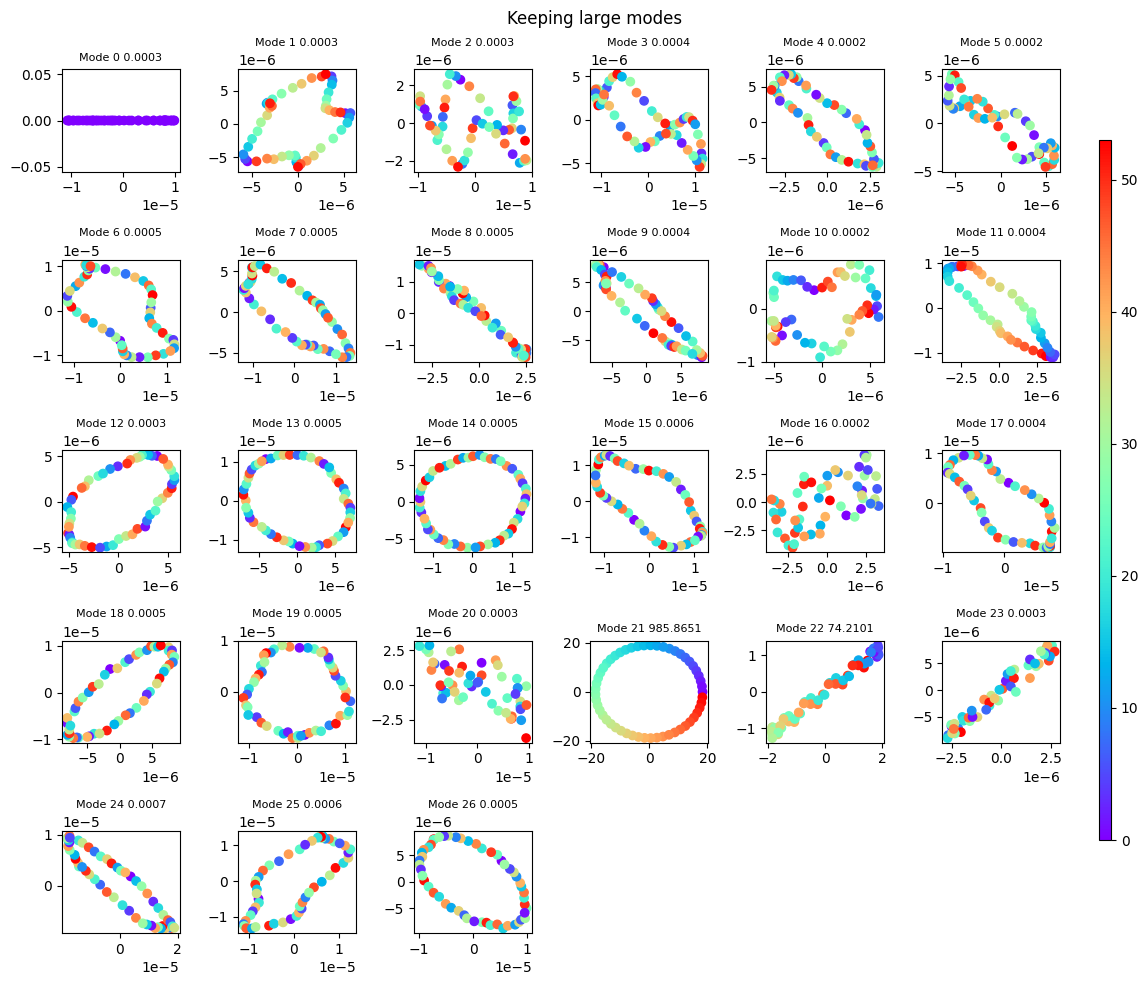

In [32]:
ablated = ablate_other_modes(model.embedding.weight.detach().cpu(), [21])
show_weights_modes(ablated, title="Keeping large modes")

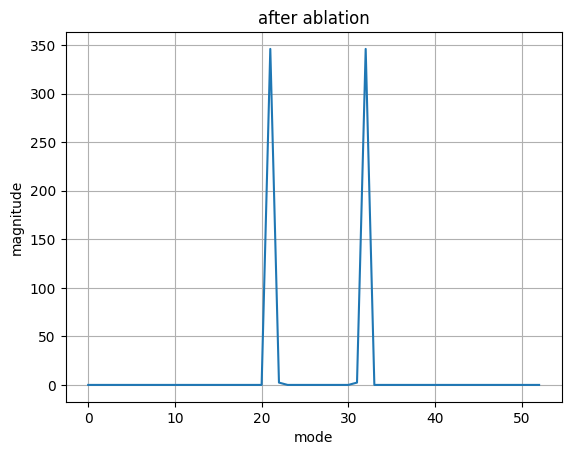

In [33]:
c, s = get_weights_modes(ablated)
mags = (c**2 + s**2).mean(dim=-1)
plt.plot(mags)
plt.xlabel("mode")
plt.ylabel("magnitude")
plt.title("after ablation")
plt.grid()
plt.show()

In [34]:
def eval_model(model, dataset, device):
  model.eval()
  avg_loss = 0
  loss_fn = t.nn.CrossEntropyLoss()
  with t.no_grad():
    for (x1, x2), y in dataset:
      out = model(x1.to(device), x2.to(device)).cpu()
      avg_loss += loss_fn(out, y)
  return avg_loss / len(dataset)

In [35]:
def get_loss_only_modes(model, modes, test_dataset, device, embed_dim=EMBED_DIM, vocab_size=P, hidden_dim=HIDDEN_SIZE, tie_unembed=False):
  model_copy = MLP(embed_dim=embed_dim, vocab_size=vocab_size, hidden_dim=hidden_dim, tie_unembed=tie_unembed)
  model_copy.to(device)
  model_copy.load_state_dict(model.state_dict())
  model_copy.eval()
  model_copy.embedding.weight.data = ablate_other_modes(model_copy.embedding.weight.detach().cpu(), modes).to(device)
  return eval_model(model_copy, test_dataset, device).item()

In [36]:
eval_model(model, test_data, device)

tensor(0.2034)

In [37]:
get_loss_only_modes(model, list(range(0, P)), test_data, device)

0.20337598025798798

In [39]:
get_loss_only_modes(model, [21], test_data, device)

5.968347072601318

# Train keeping track of individual mode suspace's loss

In [48]:
hidden_dim = 256 # Use larger hidden dim when freezing layer

In [49]:
def train_with_modes(model, train_dataset, test_dataset, batch_size, lr, n_batches, device, freeze=True, tie_unembed=False):
  model = model.to(device)
  if freeze:
    optimizer = t.optim.Adam(list(model.embedding.parameters()) + list(model.linear2.parameters()), weight_decay=0, lr=lr)
  else:
    optimizer = t.optim.Adam(model.parameters(), weight_decay=0, lr=lr)
  loss_fn = t.nn.CrossEntropyLoss()
  idx = list(range(len(train_dataset)))
  avg_loss = 0
  track_every = n_batches // 20
  print_every = n_batches // 10
  mode_loss_history = []
  for i in tqdm(range(n_batches)):
    model.train()
    # Sample random batch of data
    batch_idx = random.sample(idx, batch_size)
    X_1 = t.stack([train_dataset[b][0][0] for b in batch_idx]).to(device)
    X_2 = t.stack([train_dataset[b][0][1] for b in batch_idx]).to(device)
    Y = t.stack([train_dataset[b][1] for b in batch_idx]).to(device)
    # Gradient update
    optimizer.zero_grad()
    out = model(X_1, X_2)
    loss = loss_fn(out, Y)
    avg_loss += loss.item()
    loss.backward()
    optimizer.step()
    if i % track_every == 0:
      mode_losses = {}
      for mode in range(0, P//2 + 1):
        l_mode = get_loss_only_modes(model, [mode], test_dataset, device, hidden_dim=hidden_dim, tie_unembed=tie_unembed)
        mode_losses[mode] = l_mode
      mode_loss_history.append(mode_losses)
    if i % print_every == 0:
        val_acc = test(model, test_dataset, device)
        avg_loss /= print_every
        print(f"Batch: {i} | Loss: {avg_loss} | Val Acc: {val_acc}")
        avg_loss = 0
  val_acc = test(model, test_dataset, device)
  print(f"Final Val Acc: {val_acc}")
  return model, mode_loss_history


In [50]:
model = MLP(embed_dim=EMBED_DIM, vocab_size=P, hidden_dim=hidden_dim, tie_unembed=True)
model, mode_loss_history = train_with_modes(
    model=model,
    train_dataset=train_data,
    test_dataset=test_data,
    batch_size=BATCH_SIZE,
    lr=0.02,
    n_batches = 300,
    device = device,
    freeze = True,
    tie_unembed=True
  )

  0%|          | 1/300 [00:08<42:48,  8.59s/it]

Batch: 0 | Loss: 0.14988725980122883 | Val Acc: 0.01542111506524318


 10%|█         | 31/300 [00:24<03:09,  1.42it/s]

Batch: 30 | Loss: 4.320576842625936 | Val Acc: 0.022538552787663108


 20%|██        | 61/300 [00:41<02:24,  1.66it/s]

Batch: 60 | Loss: 3.9664076646169026 | Val Acc: 0.02609727164887307


 30%|███       | 91/300 [00:59<02:06,  1.65it/s]

Batch: 90 | Loss: 3.9131875673929852 | Val Acc: 0.03202846975088968


 40%|████      | 121/300 [01:16<01:42,  1.75it/s]

Batch: 120 | Loss: 3.8067839622497557 | Val Acc: 0.046263345195729534


 50%|█████     | 151/300 [01:32<01:24,  1.76it/s]

Batch: 150 | Loss: 3.31900041103363 | Val Acc: 0.14590747330960854


 60%|██████    | 181/300 [01:49<01:06,  1.79it/s]

Batch: 180 | Loss: 1.888022037347158 | Val Acc: 0.6026097271648873


 70%|███████   | 211/300 [02:05<00:48,  1.82it/s]

Batch: 210 | Loss: 0.7743507554133733 | Val Acc: 0.8600237247924081


 80%|████████  | 241/300 [02:22<00:32,  1.79it/s]

Batch: 240 | Loss: 0.3342403387029966 | Val Acc: 0.9062870699881376


 90%|█████████ | 271/300 [02:38<00:16,  1.81it/s]

Batch: 270 | Loss: 0.22540371070305507 | Val Acc: 0.9051008303677343


100%|██████████| 300/300 [02:47<00:00,  1.79it/s]


Final Val Acc: 0.900355871886121


<ipython-input-20-1826daf31b27>:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


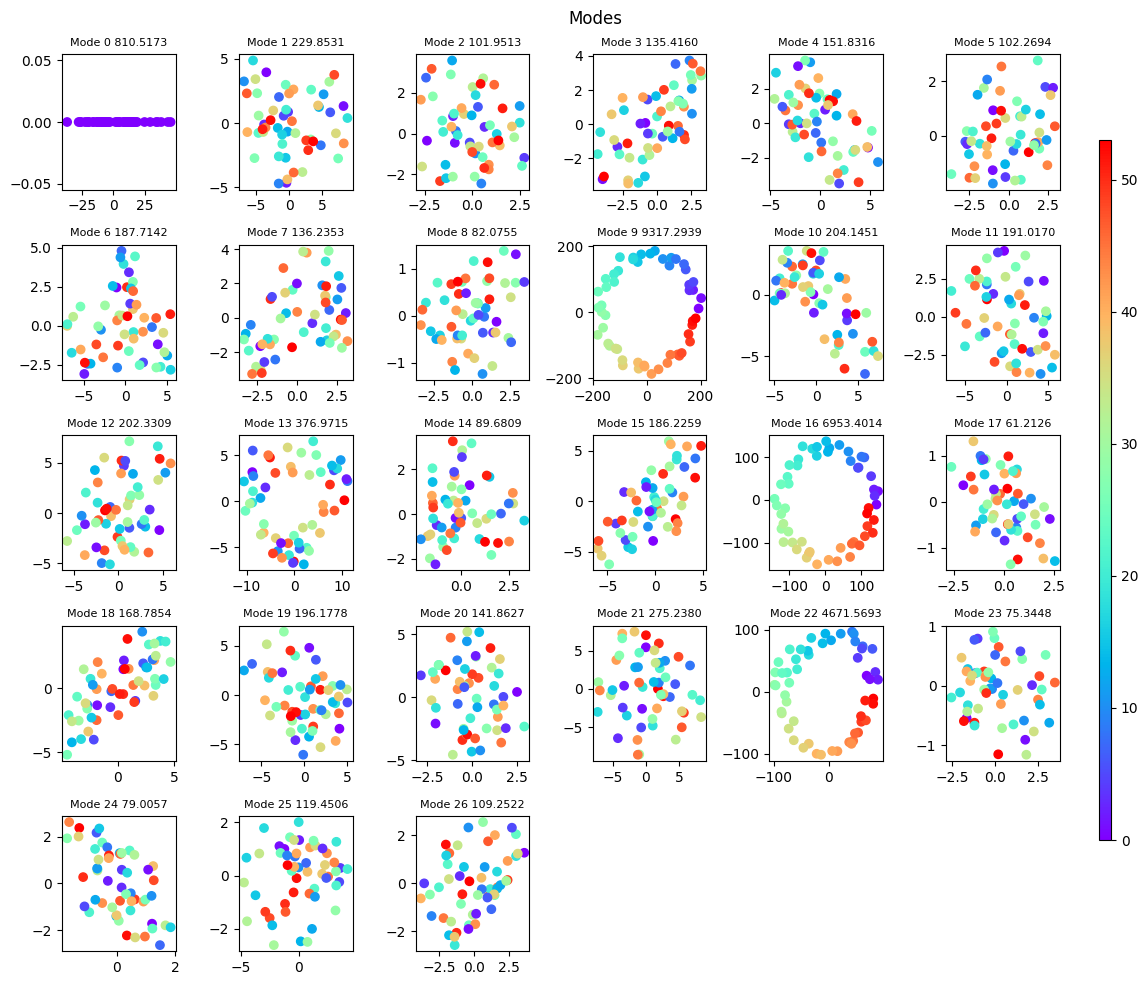

In [51]:
show_weights_modes(model.embedding.weight.detach().cpu())

In [52]:
get_loss_only_modes(model, [9, 16, 22], test_data, device, hidden_dim=hidden_dim, tie_unembed=True)

1.474334478378296

In [53]:
eval_model(model, test_data, device)

tensor(0.3111)

In [54]:
import matplotlib.cm as cm

<ipython-input-55-3570a3dd90a4>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap("rainbow", num_plots)


<Figure size 640x480 with 0 Axes>

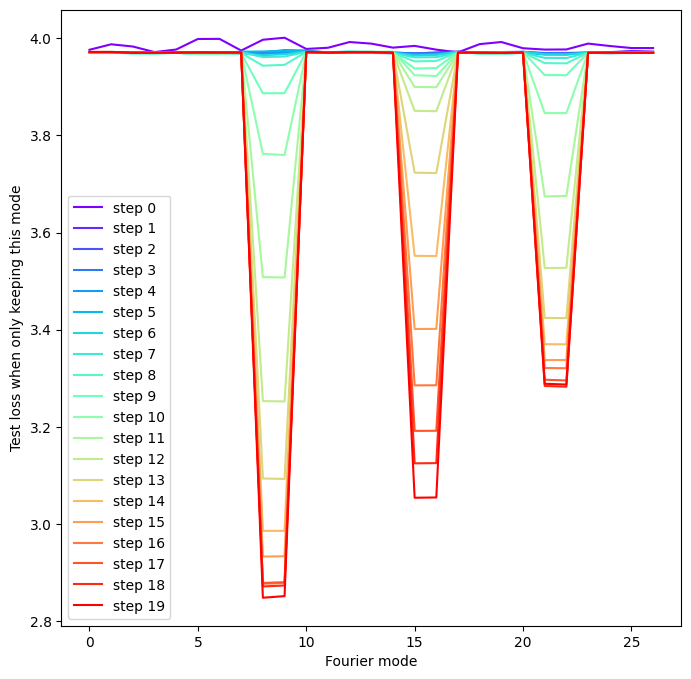

In [55]:
plt.clf()
plt.figure(figsize=(8, 8))
num_plots = len(mode_loss_history)
colormap = cm.get_cmap("rainbow", num_plots)

for idx, history in enumerate(mode_loss_history):
    color = colormap(idx)
    plt.plot(list(history.keys()), list(history.values()), color=color, label=f"step {idx}")
plt.xlabel("Fourier mode")
plt.ylabel("Test loss when only keeping this mode")
plt.legend()
plt.show()